In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import binom

# Statistical Methods for Capstone 1: Tennis

### Question 1: Are left-handed players more represented in the top 100?

Here's a quick recap from the Data Storytelling report. There have been only 1097 top 100 players in the history of the Open Era. Of those players, 14% play with their left hand. In the population of all professional tennis players, only 8% play left-handed. Is this result significant, or is the sample size too small to give a definitive answer? Let's find out.

In [2]:
# Top 100 players
players = pd.read_csv('../Resources/tennis_clean/atp_top_100_players.csv', index_col='player_id',
                      parse_dates=['birthdate'])


# All players
all_players = pd.read_csv('../Resources/tennis_clean/atp_players.csv', index_col='player_id',
                          parse_dates=['birthdate'])

# Remove unknown values from both datasets
players = players[(players.hand == 'L') | (players.hand == 'R')]
all_players = all_players[(all_players.hand == 'L') | (all_players.hand == 'R')]

Here are the numbers from the top 100 population. 

In [3]:
handedness = players.groupby('hand').size()
print(handedness)
left_100 = handedness['L'] / handedness.sum()
left_100

hand
L    153
R    933
dtype: int64


0.1408839779005525

Here are the numbers from the entire population.

In [4]:
all_handedness = all_players.groupby('hand').size()
print(all_handedness)
left_all = all_handedness['L'] / all_handedness.sum()
left_all

hand
L     1366
R    15238
dtype: int64


0.08226933269091785

The handedness of a player is either Left or Right. There is no mean or standard deviation that can be calculated from a categorical like this. However, as handedness is a special variable with only two possibilites, it can be simulated using the Binomial Distribution. The only requirements are the number of trials you wish to perform, and the probability of success. In my case, I'll define success as being left handed (I'm left handed, so I might be biased)

To test the validity of the numbers and my approach, I'll use the scipy.stats.binom.cdf method to calculate the odds of getting below 8% of the population given an 8% success rate. I'll use the total number of players as the number of trials. As expected, there is around a 50% chance of getting below (or above) the population percentage.

In [5]:
# binom.cdf(num successes, num trials, prob success)

binom.cdf(all_handedness['L'], all_handedness.sum(), left_all)

0.5072019954261486

Now for the real question. What is the likelihood that in a population equal in size to the population of top 100 players, greater than 14% turn up left handed? Given a probability of success at 8%, and a number of trials equal to the number of top 100 players, the odds are extremely low.

In [6]:
# binom.cdf(num successes, num trials, prob success)

1 - binom.cdf(handedness['L'], handedness.sum(), left_all)

4.04440925194649e-11

How can we show this graphically? I could use scipy's binomial distribution to generate random samples, but I would prefer to work with the original dataset. First I'll write a function that can generate 10,000 samples from the population of all players. I could add a generic function parameter to apply to the samples, but for now all I want is the percentage of left handed players within the sample.

In [7]:
def handy_samples(data, size=1, n=1):
    samples = np.empty(n)
    for i in range(n):
        sample = data.sample(size)
        samples[i] = sample.groupby('hand').size()['L'] / size
    return samples

Here I take 10,000 samples from the population of all players, with a size equal to the population of top 100 players. Time to stand up and stretch.

In [8]:
samples = handy_samples(all_players, size=handedness.sum(), n=10_000)

Here is the resulting distribution. It looks fairly normal to me.

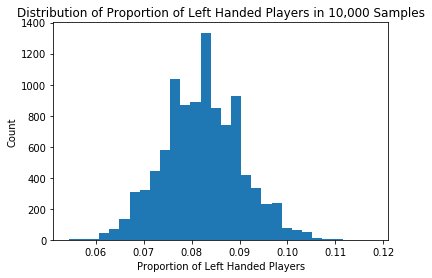

In [9]:
_ = plt.hist(samples, bins=30)
_ = plt.xlabel('Proportion of Left Handed Players')
_ = plt.ylabel('Count')
_ = plt.title('Distribution of Proportion of Left Handed Players in 10,000 Samples')

But that's not all! After adding some markers for the mean, 95% confidence interval, and the proportion in the top 100 population, I can only conclude that left handed players are significantly more represented in the top 100.

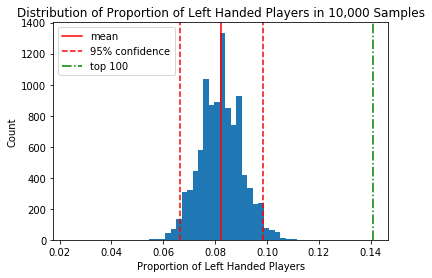

In [10]:
_ = plt.hist(samples, bins=30)
_ = plt.xlabel('Proportion of Left Handed Players')
_ = plt.ylabel('Count')
_ = plt.title('Distribution of Proportion of Left Handed Players in 10,000 Samples')

mean = np.mean(samples)
_ = plt.axvline(mean, color='red', label='mean')

confidence_interval = np.percentile(samples, [2.5, 97.5])

_ = plt.axvline(confidence_interval[0], color='red', linestyle='--', label='95% confidence')
_ = plt.axvline(confidence_interval[1], color='red', linestyle='--')

_ = plt.axvline(left_100, color='green', linestyle='-.', label='top 100')
_ = plt.axvline(mean - (left_100 - mean), color='white') # Centers the distribution

_ = plt.legend(loc='upper left')

### Question 2: How much does luck factor into a tennis match's result?

This question came to me after watching a match between Rafael Nadal and Daniil Medvedev earlier this year. Nadal made a stunning comeback from the brink of defeat, saving a match point on the way. Had that point gone to Medvedev, the result of the match would have been flipped. Tennis is quite unlike other sports in this way. The player who wins more points does not necessarily win the match. 

Unfortunately, given that each match is an independent event, there is no easy way to generate a larger sample. Instead, I'll have to pull myself up by my bootstraps and generate bootstrap statistics. To accomplish this, I have written a set of functions designed to simulate a tennis match from the ground up. The only inputs required are the first serve percentage, first serve win percentage, and second serve win percentage for each player. The output is a tuple which contains the simulated result, the points won and lost by the players, and the total number of games played.

In [11]:
# To simulate a tennis match from scratch, first you must simulate the universe.
# Or, in my case, I start from the simplest unit of a tennis match, the point.
# first_serve is a bool which is true if the server successfully hits a first serve
# fsw is the server's observed first service win percentage
# ssw is the server's observed second service win percentage

def simulate_point(first_serve, fsw, ssw):
    return (fsw if first_serve else ssw) > npr.rand()

In [12]:
%%time

simulate_point(0.5 > npr.rand(), 0.5, 0.5)

CPU times: user 16 µs, sys: 9 µs, total: 25 µs
Wall time: 28.8 µs


False

In [13]:
# The next smallest unit in a tennis match is the game. 
# In tennis, the players both start at 0.
# After winning a point, a player goes from 0 --> 15 --> 30 --> 40 --> game won.
# However, if the game is tied at 40-40, then the game is considered at deuce.
# From deuce, whichever player wins 2 straight points wins the game. This state can last indefinitely.
# fsp is the server's observed first serve percentage.
# pw and pl are the points won and lost by the server.
# From this point on, the functions will keep track of the total points won and lost by the server.
def simulate_deuce(fsp, fsw, ssw, pw, pl):
    # A deuce can theoretically last forever
    while True:
        points_won = 0
        for _ in range(2):
            points_won += simulate_point(fsp > npr.rand(), fsw, ssw)
        if points_won == 2:
            return (True, pw + 2, pl)
        elif points_won == 0:
            return (False, pw, pl + 2)
        else:
            pw += 1
            pl += 1
            

# To simulate a game, I first simulate the minimum required points.
# I then return any game deciding scores and continue the simulation as required.
# By doing this I never simulate a point that would not be played in a real game.
# fsp is the server's observed first serve percentage.
def simulate_game(fsp, fsw, ssw):
    points_won = 0
     # 4 is the minimum number of points to decide a game.
    for _ in range(4):
        points_won += simulate_point(fsp > npr.rand(), fsw, ssw)
    
    # Game won after 40-0
    if points_won == 4:
        return (True, 4, 0)
    # Game lost after 0-40
    elif points_won == 0:
        return (False, 0, 4)
    # 30-30 is identical to Deuce
    elif points_won == 2:
        return simulate_deuce(fsp, fsw, ssw, 2, 2)
    
    # Scenarios remaining: 40-15 and 15-40
    points_won += simulate_point(fsp > npr.rand(), fsw, ssw)

    # Game won after 40-15
    if points_won == 4:
        return (True, 4, 1)
    # Game lost after 15-40
    elif points_won == 1:
        return (False, 1, 4)
        
    # Scenarios remaining: 40-30 and 30-40
    points_won += simulate_point(fsp > npr.rand(), fsw, ssw)
    # Game won after 40-30
    if points_won == 4:
        return (True, 4, 2)
    # Game lost after 30-40
    elif points_won == 2:
        return (False, 2, 4)
    # Deuce
    else:
        return simulate_deuce(fsp, fsw, ssw, 3, 3)

In [14]:
%%time

# Games with long deuces may take longer.
simulate_game(0.5, 0.5, 0.5)

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 19.1 µs


(False, 2, 4)

In [15]:
# Before I can simulate a set properly, I must be able to simulate the tiebreak.
# When a set is tied at 6 games apiece, a tiebreak is played (There are exceptions to this at Grand Slam events)
# A tiebreak is basically a long game, with 7 points as the minimum threshold for victory instead of 4.
# However, the players switch serves on every odd point.

# At 5-5 or 6-6 in a tiebreak, a deuce-like scenario is created.
# Both players serve once each. In real match the order would matter but has no practical effect here.
# *_(p/o) the p and o stand for player and opponent.
def simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw, pl):
    # A tiebreak can theoretically last forever.
    while True:
        points_won = 0
        
        points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
        # When the opponent serves, the result of the simulated point is negated.
        points_won += not simulate_point(fsp_o > npr.rand(), fsw_o, ssw_o)
        
        if points_won == 2:
            return (True, pw + 2, pl)
        elif points_won == 0:
            return (False, pw, pl + 2) 
        else:
            pw += 2
            pl += 2

# I have continued the "unrolled loop" approach, as despite being more verbose it performs well.
# *_(p/o) the p and o stand for player and opponent. The player serves first.
def simulate_tiebreak(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw, pl):
    points_won = 0
    
    # 7 is the minimum number of points to decide a tiebreak.
    # In the first 7 points, the player serves 3 times to the opponents 4
    for _ in range(3):
        points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
    # When the opponent serves, the result of the simulated point is negated.
    for _ in range(4):
        points_won += not simulate_point(fsp_o > npr.rand(), fsw_o, ssw_o)
        
    # Tiebreak won after 7-0
    if points_won == 7:
        return (True, pw + 7, pl)
    # Tiebreak lost after 0-7
    elif points_won == 0:
        return (False, pw, pl + 7)
    
    # Scenarios remaining: 6-1, 5-2, 4-3, 3-4, 2-5, 1-6
    # The player serves next.
    points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
    
    # Tiebreak won after 7-1
    if points_won == 7:
        return (True, pw + 7, pl + 1)
    # Tiebreak lost after 1-7
    elif points_won == 1:
        return (False, pw + 1, pl + 7)
    
    # Scenarios remaining: 6-2, 5-3, 4-4, 3-5, 2-6
    # The player serves next.
    points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
    
    # Tiebreak won after 7-2
    if points_won == 7:
        return (True, pw + 7, pl + 2)
    # Tiebreak lost after 2-7
    elif points_won == 2:
        return (False, pw + 2, pl + 7)
    
    # Scenarios remaining: 6-3, 5-4, 4-5, 3-6
    # The opponent serves next
    points_won += not simulate_point(fsp_o > npr.rand(), fsw_o, ssw_o)
    
    # Tiebreak won after 7-3
    if points_won == 7:
        return (True, pw + 7, pl + 3)
    # Tiebreak lost after 3-7
    elif points_won == 3:
        return (False, pw + 3, pl + 7)
    # At 5-5, the tiebreak is in a state similar to deuce.
    elif points_won == 5:
        return simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw + 5, pl + 5)
    
    # Scenarios remaining: 6-4, 4-6
    # The opponent serves next
    points_won += not simulate_point(fsp_o > npr.rand(), fsw_o, ssw_o)
    
    # Tiebreak won after 7-4
    if points_won == 7:
        return (True, pw + 7, pl + 4)
    # Tiebreak lost after 4-7
    elif points_won == 4:
        return (False, pw + 4, pl + 7)
    # Scenarios remaining: 6-5, 5-6
    # The player serves next
    points_won += simulate_point(fsp_p > npr.rand(), fsw_p, ssw_p)
    
    # Tiebreak won after 7-5
    if points_won == 7:
        return (True, pw + 7, pl + 5)
    # Tiebreak lost after 5-7
    elif points_won == 5:
        return (False, pw + 5, pl + 7)
    # Scenarios remaining: 6-6, which is a deuce situation
    else:
        return simulate_tiebreak_deuce(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, pw + 6, pw + 6)

In [16]:
%%time

simulate_tiebreak(.5, .5, .5, .5, .5, .5, 0, 0)

CPU times: user 39 µs, sys: 5 µs, total: 44 µs
Wall time: 55.1 µs


(False, 12, 14)

In [17]:
# The biggest sub-unit of a tennis match is the set.
# Each set acts like a tiebreak, with points replaced by games.
# A player must win 6 games to win a set, and with two games or more than the opponent.
# In the event of a tie at 6 games apiece, a tiebreak is played.
# Scorelines of 7-5 are also possible, and can only occur from 5 games apiece.
# The players switch serves each game. 
# In the tiebreak, the player who returned in the previous game serves first.
def simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o):
    games_won = 0
    points_won = 0
    points_lost = 0
    # 6 is the minimum number of games to decide a set.
    # In the first 6 games, each player serves 3 times.
    for i in range(3):
        (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
        games_won += game_result
        points_won += pw
        points_lost += pl
        
        (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
        games_won += not game_result
        points_won += pl
        points_lost += pw
        
    # Set won after 6-0
    if games_won == 6:
        return (True, points_won, points_lost, 6)
    # Set lost after 0-6
    elif games_won == 0:
        return (False, points_won, points_lost, 6)
    
    # Scenarios remaining: 5-1, 4-2, 3-3, 2-4, 1-5
    # The player serves next.
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    # Set won after 6-1
    if games_won == 6:
        return (True, points_won, points_lost, 7)
    # Set lost after 1-6
    elif games_won == 1:
        return (False, points_won, points_lost, 7)
    
    # Scenarios remaining: 5-2, 4-3, 3-4, 2-5
    # The opponent serves next.
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 6-2
    if games_won == 6:
        return (True, points_won, points_lost, 8)
    # Set lost after 2-6
    elif games_won == 2:
        return (False, points_won, points_lost, 8)
    
    # Scenarios remaining: 5-3, 4-4, 3-5
    # The player serves next.
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    # Set won after 6-3
    if games_won == 6:
        return (True, points_won, points_lost, 9)
    # Set lost after 3-6
    elif games_won == 3:
        return (False, points_won, points_lost, 9)
    
    # Scenarios remaining: 5-4, 4-5
    # The opponent serves next.
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 6-4
    if games_won == 6:
        return (True, points_won, points_lost, 10)
    # Set lost after 4-6
    elif games_won == 4:
        return (False, points_won, points_lost, 10)
    
    # Scenarios remaining: 5-5
    # Neither player can win on the next game, so 2 games are simulated
    (game_result, pw, pl) = simulate_game(fsp_p, fsw_p, ssw_p)
    games_won += game_result
    points_won += pw
    points_lost += pl
    
    (game_result, pw, pl) = simulate_game(fsp_o, fsw_o, ssw_o)
    games_won += not game_result
    points_won += pl
    points_lost += pw
    
    # Set won after 7-5
    if games_won == 7:
        return (True, points_won, points_lost, 12)
    # Set lost after 5-7
    elif games_won == 5:
        return (False, points_won, points_lost, 12)
    # Tied at 6-6, so go to a tiebreak
    else:
        return (*simulate_tiebreak(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, points_won, points_lost), 13)

In [18]:
%%time

simulate_set(.5, .5, .5, .5, .5, .5)

CPU times: user 69 µs, sys: 0 ns, total: 69 µs
Wall time: 71.3 µs


(True, 33, 30, 12)

In [19]:
# The end is finally in sight. 
# Depending on the tournament, matches may be best of 3 or 5 sets. 
# For now, I will focus only on simulating 3 set matches.
def simulate_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o):
    sets_won = 0
    points_won = 0
    points_lost = 0
    games_played = 0
    
    # Before each match, a coin is tossed to determine who serves first.
    coin_toss = npr.rand() > 0.5
    # First set
    if coin_toss:
        (set_result, pw, pl, games) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
    else:
        (set_result, pw, pl, games) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
        
    # Second set
    # The server is instead determined by the total games played in the previous sets.
    # If total games is even, then the serve order stays the same.
    if (games_played % 2 == 0 and coin_toss) or (games_played % 2 == 1 and not coin_toss):
        (set_result, pw, pl, games) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
    else:
        (set_result, pw, pl, games) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games

        
    # If the score is 2-0 or 0-2, return with the results.
    if sets_won == 2:
        return (True, points_won, points_lost, games_played)
    elif sets_won == 0:
        return (False, points_won, points_lost, games_played)
       
    # Otherwise, simulate the deciding set              
    if (games_played % 2 == 0 and coin_toss) or (games_played % 2 == 1 and not coin_toss):
        (set_result, pw, pl, games) = simulate_set(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
        sets_won += set_result
        points_won += pw
        points_lost += pl
        games_played += games
    else:
        (set_result, pw, pl, games) = simulate_set(fsp_o, fsw_o, ssw_o, fsp_p, fsw_p, ssw_p)
        sets_won += not set_result
        points_won += pl
        points_lost += pw
        games_played += games
                
    # Whether the score is 2-1 or 1-2, return with the results.
    if sets_won == 2:
        return (True, points_won, points_lost, games_played)
    else:
        return (False, points_won, points_lost, games_played)

In [20]:
%%time

simulate_match(.5, .5, .5, .5, .5, .5)

CPU times: user 328 µs, sys: 6 µs, total: 334 µs
Wall time: 357 µs


(True, 98, 91, 29)

Phew. Now that all of that is out of the way, I can write a function to create a variable number of bootstrap samples to explore.

In [21]:
def bootstrap_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, n=1):
    results = np.empty(n, dtype=object)
    
    for i in range(n):
        results[i] = simulate_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o)
    
    return results

On my machine, I can simulate the results of 10,000 matches in just over 2 seconds. Not bad.

In [22]:
%%time

bootstrap_match(.5, .5, .5, .5, .5, .5, 10000)

CPU times: user 1.34 s, sys: 6.06 ms, total: 1.34 s
Wall time: 1.35 s


array([(True, 109, 96, 34), (False, 118, 117, 35), (False, 66, 80, 19),
       ..., (True, 98, 84, 31), (False, 84, 93, 29), (False, 90, 97, 28)],
      dtype=object)

It's finally time to look at the simulated matches between Nadal and Medvedev. I generated 10,000 bootstrapped samples for analysis. All results with a value of True represent a simulated match in which Nadal won.

In [23]:
# .64, .72, .58 are Nadal's first serve percentage, first serve win percentage and second serve win percentage
# from the match in question.
# .6, .75, .52 are Medvedev's first serve percentage, first serve win percentage and second serve win percentage
# from the match in question.
npr.seed(90)
bootstraps = pd.DataFrame.from_records(bootstrap_match(.64, .72, .58, .6, .75, .52, 10000),
                            columns=['result', 'points_won', 'points_lost', 'games'])

55% of the simulated matches resulted in a victory for Nadal. This result makes sense, as the statistics for both players are quite similar.

In [24]:
bootstraps.result.sum() / bootstraps.result.size

0.5559

To represent the simulations graphically, I plotted two separate histograms, one for the wins and one for the losses. The x-axis represents the point differential of the match, or the points won by Nadal subtracted by the points won by Medvedev. I also marked the 95% confidence intervals for both the wins and loss point differentials, and the actual point defferential for the match.

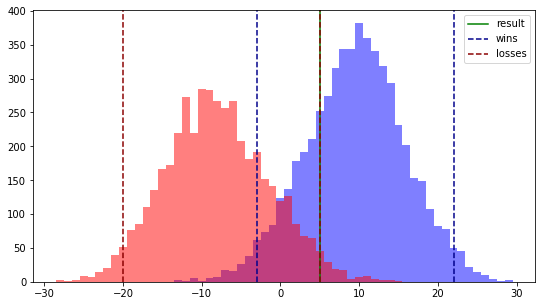

In [25]:
plt.rcParams['figure.figsize'] = [9, 5]

bootstraps['points_diff'] = bootstraps.points_won - bootstraps.points_lost
bootstraps['points_won_percentage'] = bootstraps.points_won / (bootstraps.points_won + bootstraps.points_lost)
wins = bootstraps[bootstraps.result == True]
losses = bootstraps[bootstraps.result == False]

confidence_wins = np.percentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(bootstraps.points_diff) + 1) - abs(bootstraps.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)


_ = plt.axvline(108 - 103, linestyle='-', color='green', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='--', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='--', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='--', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='--', color='darkred')

_ = plt.legend()

A similar plot was made by substituting the point differential for points won percentage instead. In both cases, the match result fell between the confidence intervals for both a win and a loss. It was a close match, so it makes sense that it could have gone either way.

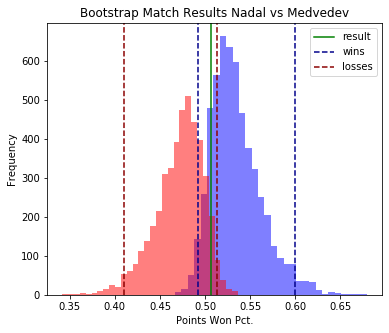

In [26]:
plt.rcParams['figure.figsize'] = [6, 5]

confidence_wins = np.percentile(wins.points_won_percentage, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_won_percentage, [2.5, 97.5])

_ = plt.hist(wins.points_won_percentage, bins=30, color='blue', alpha=0.5)
_ = plt.hist(losses.points_won_percentage, bins=30, color='red', alpha=0.5)

_ = plt.axvline(108/213, linestyle='-', color='green', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='--', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='--', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='--', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='--', color='darkred')

plt.legend()
plt.xlabel('Points Won Pct.')
plt.ylabel('Frequency')
_ = plt.title('Bootstrap Match Results Nadal vs Medvedev')

I replicated the above plot using real match data instead of simulated matches. 

In [27]:
matches = pd.read_csv('../Resources/tennis_clean/atp_top_100_matches.csv',
                      index_col=['player_id', 'tournament_id', 'match_id'],
                      parse_dates=['tournament_date'])
matches['points_diff'] = matches.points_won - (matches.points - matches.points_won)

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Most matches end with a positive points differential for the winner, and a negative points differential for the loser. When the differental is close to zero, the odds are nearly equal for a win or a loss. However, there are a few matches where the expected result is flipped. A positive points differential that ends in a loss, or a negative points differential that results in a win.

In [32]:
matches.points_diff

player_id  tournament_id  match_id
100011     1968-401       4            NaN
                          8            NaN
           1968-D013      1            NaN
                          3            NaN
           1968-520       69           NaN
                                      ... 
206173     2019-7485      293         21.0
                          297          5.0
                          299        -20.0
           2019-0337      275         14.0
                          288         -8.0
Name: points_diff, Length: 299758, dtype: float64

In [28]:
plt.rcParams['figure.figsize'] = [6, 4]

wins = matches[matches.result == 'W']
losses = matches[matches.result == 'L']

confidence_wins = np.nanpercentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.nanpercentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(matches.points_diff) + 1) - abs(matches.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)

_ = plt.axvline(confidence_wins[0], linestyle='-', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='-', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='-', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='-', color='darkred')

_ = plt.legend()
plt.xlabel('Points Differential')
plt.ylabel('Frequency')
_ = plt.title('Actual Match Results Points Differential Histogram')

ValueError: arange: cannot compute length

I decided to investigate these "oddities." I extracted all matches where the points differential and match result didn't add up.

In [ ]:
odd_matches = matches[(matches.best_of == 3) &
                      ((matches.points_diff < 0) & (matches.result == 'W')) | 
                      ((matches.points_diff > 0) & (matches.result == 'L'))]
odd_matches[['points_diff', 'result']]

bins = np.arange(np.ptp(odd_matches.points_diff) + 1) - abs(odd_matches.points_diff.min()) - 0.5
_ = plt.hist(odd_matches.points_diff, bins=bins, color='green', alpha=0.5)

Taking a look at the wins first, I sorted by points won percentage, and discarded any matches that ended in a player retiring or withdrawing early from a match. The remaining matches had eye-popping scores! The top row describes a match in which Andreas Seppi won only 37% of the points, but dominated his opponent in game score 12-4. How is that possible?

In [ ]:
odd_wins = odd_matches[odd_matches.points_diff < 0]
odd_losses = odd_matches[odd_matches.points_diff > 0]

odd_wins = odd_wins[~((odd_wins.score.str.contains('RET')) | (odd_wins.score.str.contains('DEF')))]
odd_wins.sort_values('points_won_percentage')[['player_name', 'score', 'points_diff', 'points_won_percentage']].head()

Luckily I can use my bootstrap function to calculate the likelihood of a similar result. As expected, a win under such conditions is highly improbable! Our simulated Seppi wins the match only .1% of the time.

In [ ]:
lucky_win = odd_wins.loc[105373,'2015-339', 16.0]

fsp_p = lucky_win.first_serve_percentage
fsw_p = lucky_win.first_serves_won_percentage 
ssw_p = lucky_win.second_serves_won_percentage
fsp_o = (lucky_win.first_serve_return_points_won / lucky_win.first_serve_return_points_won_percentage) / lucky_win.return_points
fsw_o = 1 - lucky_win.first_serve_return_points_won_percentage
ssw_o = 1 - lucky_win.second_serve_return_points_won_percentage

bootstraps = pd.DataFrame.from_records(bootstrap_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, 10000),
                                       columns=['result', 'points_won', 'points_lost', 'games'])

bootstraps.result.sum() / bootstraps.result.size

After plotting the bootstrap samples, it can be seen that the result falls outside of the 95% confidence interval for the wins histogram. What a lucky win for Seppi!

In [ ]:
plt.rcParams['figure.figsize'] = [6, 5]

bootstraps['points_diff'] = bootstraps.points_won - bootstraps.points_lost
bootstraps['points_won_percentage'] = bootstraps.points_won / (bootstraps.points_won + bootstraps.points_lost)
wins = bootstraps[bootstraps.result == True]
losses = bootstraps[bootstraps.result == False]

confidence_wins = np.percentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(bootstraps.points_diff) + 1) - abs(bootstraps.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)


_ = plt.axvline(lucky_win.points_diff, linestyle='-.', color='blue', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='-', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='-', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='-', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='-', color='darkred')


_ = plt.xlabel('Point Differential')
_ = plt.ylabel('Frequency')
_ = plt.title('Luckiest Win Bootstrap Analysis')
_ = plt.legend()

How about the other end of the spectrum? What is the unluckiest loss? Ignoring results where players retired or withdrew early, unfortunate losses pop up. The first row is the inverse of Andreas Seppi's match, so I'll take a look at the second result. The score is even more lopsided. Despite winning 62% of the points, Christo Van Rensburg lost by a gamescore of 3-12. 

In [ ]:
odd_losses = odd_losses[~((odd_losses.score.str.contains('RET')) | (odd_losses.score.str.contains('DEF')))]
odd_losses.sort_values('points_won_percentage', ascending=False)[['player_name', 'score', 'points_diff', 'points_won_percentage']].head()

I doubt that he would like to hear that my simulations predicted that he should have won 99.96% of the time. 

In [ ]:
unlucky_loss = odd_losses.loc[100870, '1991-375', 20.0]

fsp_p = unlucky_loss.first_serve_percentage
fsw_p = unlucky_loss.first_serves_won_percentage 
ssw_p = unlucky_loss.second_serves_won_percentage
fsp_o = (unlucky_loss.first_serve_return_points_won / unlucky_loss.first_serve_return_points_won_percentage) / unlucky_loss.return_points
fsw_o = 1 - unlucky_loss.first_serve_return_points_won_percentage
ssw_o = 1 - unlucky_loss.second_serve_return_points_won_percentage

bootstraps = pd.DataFrame.from_records(bootstrap_match(fsp_p, fsw_p, ssw_p, fsp_o, fsw_o, ssw_o, 10000),
                                       columns=['result', 'points_won', 'points_lost', 'games'])

bootstraps.result.sum() / bootstraps.result.size

Luckily his point differential falls squarely inside the middle of the mean... for the wins that is! I think that I can dub this the unluckiest loss in history.

In [ ]:
plt.rcParams['figure.figsize'] = [6, 5]

bootstraps['points_diff'] = bootstraps.points_won - bootstraps.points_lost
bootstraps['points_won_percentage'] = bootstraps.points_won / (bootstraps.points_won + bootstraps.points_lost)
wins = bootstraps[bootstraps.result == True]
losses = bootstraps[bootstraps.result == False]

confidence_wins = np.percentile(wins.points_diff, [2.5, 97.5])
confidence_losses = np.percentile(losses.points_diff, [2.5, 97.5])

bins = np.arange(np.ptp(bootstraps.points_diff) + 1) - abs(bootstraps.points_diff.min()) - 0.5
_ = plt.hist(wins.points_diff, bins=bins, color='blue', alpha=0.5)
_ = plt.hist(losses.points_diff, bins=bins, color='red', alpha=0.5)


_ = plt.axvline(unlucky_loss.points_diff, linestyle='-.', color='red', label='result')

_ = plt.axvline(confidence_wins[0], linestyle='-', color='darkblue', label='wins')
_ = plt.axvline(confidence_wins[1], linestyle='-', color='darkblue')

_ = plt.axvline(confidence_losses[0], linestyle='-', color='darkred', label='losses')
_ = plt.axvline(confidence_losses[1], linestyle='-', color='darkred')

_ = plt.xlabel('Point Differential')
_ = plt.ylabel('Frequency')
_ = plt.title('Unluckiest Loss Bootstrap Analysis')
_ = plt.legend()

## Conclusions

What can be drawn from these results? I think that they provide a good sense that tennis match outcomes are not the best predictor of player performance. Because of how tennis scoring works, a player can win a match despite losing more points than their opponent. While results are important, I would not use them as the primary guage for a player's future or current success.